# Final Project

Intraday ETF trading based on 10-sec aggregated equity market data.

#### Name:  Xuan Zhang

## Data Set

SPY is an Exchange Traded Fund (ETF) that replicates the S&P 500 index, and trades in exchanges like ordinary equity.  
SPY is the most liquid (heavily traded) equity asset in the US.  

For all trading days in June 2018 we have aggregated in 10-sec intervals the trading activity in SPY across all exchanges.  
The dataset is provided in the file `Resources/Data/spy-10sec-201806.csv` at the class site.   
Each row corresponds to a specific 10-sec interval for the corresponding trading day.  
A row reports trading activity within the time period that *ends* at the corresponding interval.  

Regular trading hours in the US are from 09:30 to 16:00.  
You will notice that the 09:30 and 16:00 intervals have much larger traded volume relative to neighboring ones.  
This is because the market opens at 09:30 with an opening auction and closes at 16:00 with a closing auction.  
The consolidated limit order book is the collection of all quotes to buy (bid) and to sell (ask).  
Bid and ask prices/sizes are quotes, i.e. proposals to trade a given quantity at a given price.  
VWAP is the volume weighted average of prices at which trades actually occurred.  




|Column              | Description  |
---------------------|--------------|
|volume              | Number of shares traded within the interval  ($\sum_i V_i $,   summing over all trades $i$)          |
|vwap                | Volume Weighted Average Price ( $VWAP = \sum_i V_i P_i / \sum_i V_i$,   summing over all trades $i$) |
|lowPx/highPx        | Lowest and highest trade prices within the interval                               |
|lastBidPx/lastAskPx | Last bid and ask price in the interval                         |
|lastBidSz/lastAskSz | Last bid and ask sizes (in hundreds of shares) in the interval |


#### Feature engineering

Derived quantities of interest are

1. The Close Location Value (CLV) indicator. This is an intraday adaptation of a classic technical indicator. It is defined as  
$$
CLV_t = \frac{VWAP_t - (lowPx_t + highPx_t)/2}{(highPx_t - lowPx_t)/2}
$$
It measures the location of the VWAP within interval $t$, relative to the mid-point price between low and high price.  

2. The last *quote imbalance* of interval $t$, defined as 
$$
Imbal_t = \frac{lastBidSz_t - lastAskSz_t}{lastBidSz_t + lastAskSz_t}
$$
By construction $-1 \le Imbal \le 1$.  
When $Imbal \rightarrow 1$, there is much more interest to buy than to sell. 
Conversely, when $Imbal \rightarrow -1$ there is much more interest to sell than to buy.  

3. The log-transformed volume defined as $logVolume = log10(Volume)$  
When working with volume-like quantities (non-negative) taking logs is a common normalization.  
Either base 10 or natural logs can be used, base 10 logs may be easier to interpret.

We are also interested in the $N$-period forward return in basis points
$$
\mathrm{fwdRetNBps}_t = 10000 * \left(\frac{VWAP_{t+N}}{VWAP_t} - 1\right)
$$

## Problem

#### Objective
+ Construct ML models that use features derived from market observables, to predict price direction in future periods
+ Assess the models using 10-sec as well as 1-min aggregation periods

#### Data Preparation 
+ Load the SPY 10-sec data
+ Calculate the CLV and the last quote imbalance for each interval. If highPx is equal to lowPx for an interval, set the CLV value to 0.
+ Calculate the 1-period forward VWAP returns in basis points
+ Split the dataset into training sample with the first 16 days, and testing sample with the remaining 4 trading days.
+ Use the average VWAP in the training set a reference price. Call this $\mathrm{RefPx}$.
+ Compute a cutoff return in basis points as:  $\mathrm{cutRetBps} = 10000 * (0.02) / \mathrm{RefPx}$  
  This return corresponds to VWAP movement of twice the typical bid-ask spread (i.e 2 * 0.01)
+ Add a new column called pxDir1 (price direction) and label the 1-period forward price movement as follows:  
  * If fwdRet1Bps > cutRetBps then pxDir1 = +1  
  * If abs(fwdRet1Bps) <= cutRetBps then pxDir1 = 0  
  * If fwdRet1Bps < - cutRet1Bps then pxDir1 = -1  
  Therefore pxDir is a class variable taking values in the set $\{-1, 0, 1\}$.
+ Re-aggregate the 10-sec data into 1-min data and store them in a new data frame.
+ Repeat the process above (CLV, quote imbalance, forward returns, price direction labeling) with the 1-min data.

#### Modeling (60 points)

+ Exploratory data analysis (EDA) which should contain:   
    * univariate distributions of features: logVolume, clv, imbalance  
    * univariate distributions of targets: fwdRet1Bps, pxDir1  
    * any other distribution that may reveal a relationship between target and features  
    * correlation heat map  
+ Construction of a *baseline* model, to be used as a reference.  
  The baseline model predicts the price direction class $C=\{-1, 0, 1\}$ randomly using the class empirical probability of occurence.  
$$
\mathbb{P}(C=\pm 1) = \frac{N_{train}(C=\pm 1)}{N_{train}}, \quad 
\mathbb{P}(C=0) = \frac{N_{train}(C=0)}{N_{train}}
$$
Estimate the empirical probabilities of the baseline model using the training set.  
Make predictions for pxDir1 (simply sample the multinomial distribution) and use the testing set to report  

|Model               | Accuracy  | Precision  | Recall | F1wght | F1micro | 
---------------------|-----------|------------|--------|---------|---------|
|Baseline            | ...       | ...        | ...    | ...     | ...     |

Precision, Recall and F1wght should be measured "weighted" to account for class occurence and potential imbalance.  
F1micro is the "micro" F1 score, i.e. it first computes total true/false positives/negatives first and then computes the F1 score.

+ Construct *two* models, of which one should be neural net based.  
  The other could be any of the classic ML models (Logistic, SVM, Forest, AdaBoost, ...)  
  Train and tune the models in order to forecast the target variable pxDir1.  
  Evaluate the models on the test sample and add their performance metrics to the table above.  
  
+ Reaggregate the data using 1-min intervals and repeat the model runs 

+ Present your conclusions about the best model on the 10-sec and 1-min aggregated data

#### Extra Improvement

Attempt to improve model performance by introducing one extra feature variable, derived from the existing market data.  
The extra variable could be either some kind of moving average or an intraday adaptation of a technical indicator.  
Measure the performance improvement for the 10-sec and 1-min dataset.

## Solution

## Package

In [817]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.stats as stats
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.initializers import RandomNormal, he_normal
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, SimpleRNN, LSTM

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

from numpy.random import seed

np.random.seed(42)

In [818]:
spy_10sec=pd.read_csv("spy-10sec-201806.csv")
spy_10sec.head()

,date,time,sym,volume,vwap,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz
0,2018-06-01,09:30:00,SPY,395424,272.459140,272.320007,272.489990,272.359985,272.380005,14,100
1,2018-06-01,09:30:10,SPY,55692,272.395593,272.339996,272.489990,272.399994,272.410004,9,50
2,2018-06-01,09:30:20,SPY,85164,272.443104,272.390015,272.470001,272.450012,272.459991,18,7
3,2018-06-01,09:30:30,SPY,26973,272.441112,272.420013,272.459991,272.429993,272.440002,5,20
4,2018-06-01,09:30:40,SPY,77809,272.440219,272.410004,272.480011,272.420013,272.429993,1,13


# split raw data into train data and test data

In [819]:
def get_train_test(rawdata):
    #calculate CLV
    rawdata["CLV"]=(rawdata["vwap"]-(rawdata["lowPx"]+rawdata["highPx"])/2)/((rawdata["highPx"]-rawdata["lowPx"])/2)
    rawdata.loc[rawdata["lowPx"]==rawdata["highPx"],"CLV"]=0
    
    #calculate Imbal
    rawdata["Imbal"]=(rawdata["lastBidSz"]-rawdata["lastAskSz"])/(rawdata["lastBidSz"]+rawdata["lastAskSz"])

    #calculate logvolume
    logvolume=lambda x: math.log(x)/math.log(10)
    rawdata["logvolume"]=rawdata["volume"].apply(logvolume)
    
    #calculate fwdRet1Bps
    rawdata["fwdRet1Bps"]=(rawdata["vwap"].shift(periods=-1)/rawdata["vwap"]-1)*10000

    #calculate pxDir1
    RefPx=rawdata["vwap"].mean()
    cutRetBps=10000*(0.02)/RefPx
    rawdata["pxDir1"]=0
    rawdata.loc[rawdata["fwdRet1Bps"]>cutRetBps,"pxDir1"]=1
    rawdata.loc[rawdata["fwdRet1Bps"]<-cutRetBps,"pxDir1"]=-1
    
    #get train and test data
    getday=lambda x:x.split("-")[2]
    day=rawdata["date"].apply(getday)
    endtrain=day.unique()[16-1]
    num=sum(day<=endtrain)
    X_train=rawdata.iloc[0:num,[11,12,13,14,15]]
    X_test=rawdata.iloc[num:,[11,12,13,14,15]]
    
    return X_train,X_test
    

## Get train and test data

In [820]:
Xsec_train,Xsec_test=get_train_test(spy_10sec)
Xsec_train.head()

,CLV,Imbal,logvolume,fwdRet1Bps,pxDir1
0,0.637020,-0.754386,5.597063,-2.332345,-1
1,-0.258679,-0.694915,4.745793,1.744181,1
2,0.327454,0.440000,4.930256,-0.073097,0
3,0.055529,-0.600000,4.430929,-0.032791,0
4,-0.136794,-0.857143,4.891030,-0.013157,0


In [821]:
Xsec_test.head()

,CLV,Imbal,logvolume,fwdRet1Bps,pxDir1
37451,0.383014,-0.886792,5.626451,0.168145,0
37452,0.228932,0.428571,5.011156,-0.803343,-1
37453,-0.223818,0.941748,4.834650,-1.221293,-1
37454,-0.607448,0.980198,4.527075,1.846138,1
37455,0.445840,-0.428571,4.564654,-0.488553,0


## univariate distributions of features: logVolume, clv, imbalance

### The correlation among CLV, Imbal, logvolume, fwdRet1Bps, pxDir1. We can see that they don't have strong correlation.  The correlation between fwdRet1Bps and pxDir1 is the strongest.

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text yticklabel objects>)

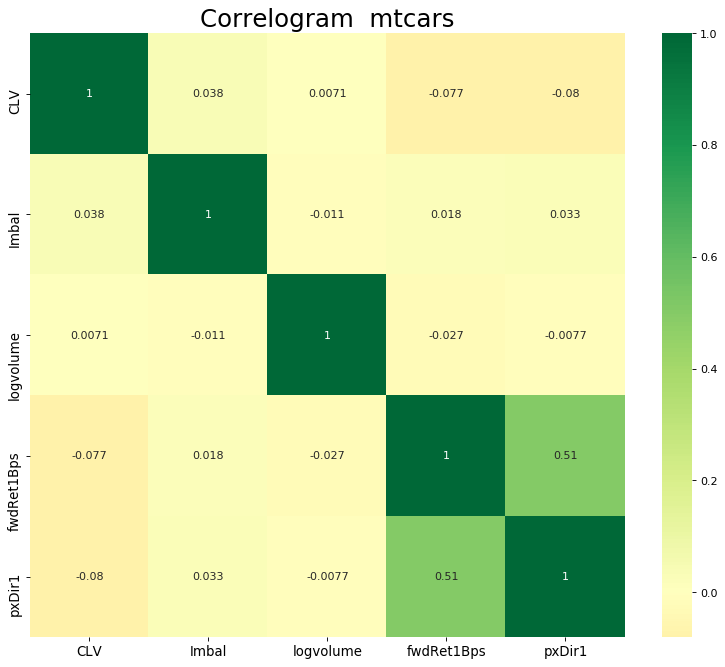

In [822]:
# Plot
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(Xsec_train.corr(), xticklabels=Xsec_train.corr().columns, yticklabels=Xsec_train.corr().columns, cmap='RdYlGn', center=0, annot=True)
 
# Decorations
plt.title('Correlogram  mtcars', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

### I used normal distribution to fit the CLV, Imbal, logvolume, fwdRet1Bps, pxDir1. According to the pricture, normal distribution is a good fit for CLV, logvolume and fwdRet1Bp. As for mbal and pxDir1, we can see that there is no usual distribution to fit them according to their pdf.

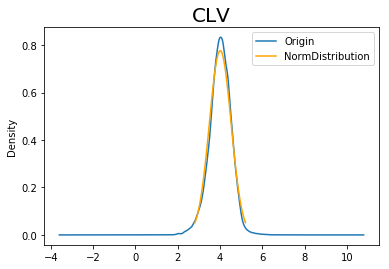

In [823]:
M_S = stats.norm.fit(Xsec_train["logvolume"])                            # 正态拟合的平均值与标准差
Xsec_train["logvolume"].plot(kind='kde')                                 # 原本的概率密度分布图

normalDistribution = stats.norm(M_S[0], M_S[1])                   # 绘制拟合的正态分布图
x = np.linspace(normalDistribution.ppf(0.01), normalDistribution.ppf(0.99), 100)
plt.plot(x, normalDistribution.pdf(x), c='orange')
plt.title('CLV', size=20)
plt.legend(['Origin', 'NormDistribution'])

plt.show()

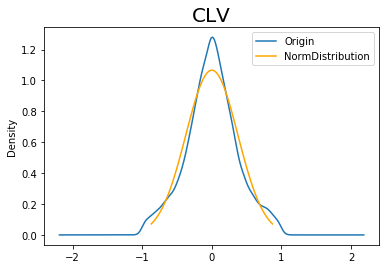

In [824]:
M_S = stats.norm.fit(Xsec_train["CLV"])                            # 正态拟合的平均值与标准差
Xsec_train["CLV"].plot(kind='kde')                                 # 原本的概率密度分布图

normalDistribution = stats.norm(M_S[0], M_S[1])                   # 绘制拟合的正态分布图
x = np.linspace(normalDistribution.ppf(0.01), normalDistribution.ppf(0.99), 100)
plt.plot(x, normalDistribution.pdf(x), c='orange')
plt.title('CLV', size=20)
plt.legend(['Origin', 'NormDistribution'])

plt.show()

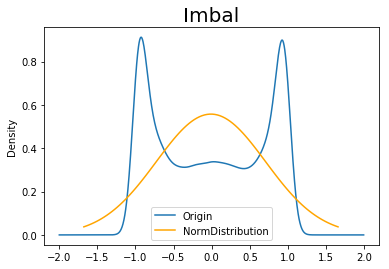

In [825]:
M_S = stats.norm.fit(Xsec_train["Imbal"])                            # 正态拟合的平均值与标准差
Xsec_train["Imbal"].plot(kind='kde')                                 # 原本的概率密度分布图

normalDistribution = stats.norm(M_S[0], M_S[1])                   # 绘制拟合的正态分布图
x = np.linspace(normalDistribution.ppf(0.01), normalDistribution.ppf(0.99), 100)
plt.plot(x, normalDistribution.pdf(x), c='orange')
plt.title('Imbal', size=20)
plt.legend(['Origin', 'NormDistribution'])

plt.show()

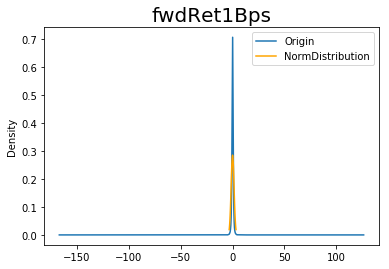

In [826]:
M_S = stats.norm.fit(Xsec_train["fwdRet1Bps"])                            # 正态拟合的平均值与标准差
Xsec_train["fwdRet1Bps"].plot(kind='kde')                                 # 原本的概率密度分布图

normalDistribution = stats.norm(M_S[0], M_S[1])                   # 绘制拟合的正态分布图
x = np.linspace(normalDistribution.ppf(0.01), normalDistribution.ppf(0.99), 100)
plt.plot(x, normalDistribution.pdf(x), c='orange')
plt.title('fwdRet1Bps', size=20)
plt.legend(['Origin', 'NormDistribution'])

plt.show()

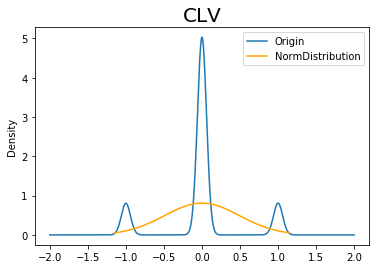

In [827]:
M_S = stats.norm.fit(Xsec_train["pxDir1"])                            # 正态拟合的平均值与标准差
Xsec_train["pxDir1"].plot(kind='kde')                                 # 原本的概率密度分布图

normalDistribution = stats.norm(M_S[0], M_S[1])                   # 绘制拟合的正态分布图
x = np.linspace(normalDistribution.ppf(0.01), normalDistribution.ppf(0.99), 100)
plt.plot(x, normalDistribution.pdf(x), c='orange')
plt.title('CLV', size=20)
plt.legend(['Origin', 'NormDistribution'])

plt.show()

## transform data to get X_train, y_train, X_test, y_test

In [828]:
n_classes=3
def getinput(Xsec_train, Xsec_test):
    X_train=np.array(Xsec_train.iloc[:,0:3])
    y_train=np.array(Xsec_train.iloc[:,4])
    X_test=np.array(Xsec_test.iloc[:,0:3])
    y_test=np.array(Xsec_test.iloc[:,4])
    return X_train,y_train,X_test,y_test

In [829]:
X_train,y_train,X_test,y_test = getinput(Xsec_train,Xsec_test)

In [830]:
p1=sum(Xsec_train["pxDir1"]==1)/Xsec_train.shape[0]
p_1=sum(Xsec_train["pxDir1"]==-1)/Xsec_train.shape[0]
p0=1-p1-p_1

## baseline model

In [831]:
dmy_clf = DummyClassifier(strategy="stratified")
dmy_clf.fit(X_train, y_train)
y_pred=dmy_clf.predict(X_test)


def getoutcome(y_test, y_pred,model):
    accuracy=accuracy_score(y_test, y_pred)
    precision=precision_score(y_test, y_pred, average='weighted')
    recall=recall_score(y_test, y_pred, average='weighted')
    F1wght=f1_score(y_test, y_pred, average='weighted')
    F1micro=f1_score(y_test, y_pred, average='micro')
    classreport=pd.DataFrame({"Model":model,"Accuracy":accuracy,"Precision":precision,
                          "Recall":recall,"F1wght":F1wght,"F1micro":F1micro},index=[0])
    classreport.set_index(["Model"], inplace=True)
    return classreport
classreportbase=getoutcome(y_test, y_pred,"baseline")
classreportbase

,Accuracy,Precision,Recall,F1wght,F1micro
Model,,,,,
baseline,0.434216,0.367955,0.434216,0.377209,0.434216


## I use logistic model to predict

## logistic model

In [832]:
lgm = LogisticRegression(C=1e-5,solver='lbfgs',  multi_class='multinomial',max_iter=1000,penalty='l2')
lgm.fit(X_train,  y_train)
y_pred = lgm.predict(X_test)
getoutcome(y_test,y_pred,"logistic")

D:\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,F1wght,F1micro
Model,,,,,
logistic,0.49968,0.24968,0.49968,0.332977,0.49968


### Through the outcome, the logistic regression is better than baseline model

## Then I use RNN model to predict

In [833]:
M=3
def getrnntrain(X_train,y_train, X_test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_train = scaler.fit_transform(X_train)
    X_train_ =np.reshape(X_train,[-1,M,1])
    X_test = scaler.fit_transform(X_test)
    X_test_ =np.reshape(X_test,[-1,M,1])
    y= to_categorical(y_train, n_classes)
    y = y[:, [2,0,1]] 
    return X_train_, X_test_,y 
X_train_rnn, X_test_rnn, y_rnn=getrnntrain(X_train,y_train, X_test)

In [834]:
rnn_input_shape=(M,1)
rnn1_layers = 1
n_units = 256
rnn1_drop_rate = 0.4

rnn1 = Sequential()
rnn1.add(SimpleRNN(input_shape=rnn_input_shape, units=n_units, activation='relu'))
rnn1.add(Dropout(rnn1_drop_rate))
for i in range(rnn1_layers - 1):
    rnn1.add(SimpleRNN(input_shape=rnn_input_shape, units=n_units, activation='relu'))
    rnn1.add(Dropout(rnn1_drop_rate))
rnn1.add(Dense(n_classes, activation='softmax'))
rnn1.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_77 (SimpleRNN)    (None, 256)               66048     
_________________________________________________________________
dropout_77 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 3)                 771       
Total params: 66,819
Trainable params: 66,819
Non-trainable params: 0
_________________________________________________________________


In [835]:
# compile, fit and evaluate
rnn1.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

rnn1_batch_size = 1000
rnn1_epochs = 10
rnn1_val_split = 0.1 
# create an early stopping callback
rnn1_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)

rnn1_hist = rnn1.fit(X_train_rnn, y_rnn, batch_size=rnn1_batch_size, epochs=rnn1_epochs, validation_split=rnn1_val_split, callbacks=[rnn1_es], verbose=1)
#rnn1_val_score = rnn1.evaluate(X_test, y_test, verbose=0)


#print('Test loss score: {0:.4f}'.format(rnn1_val_score[0]))
#print('Test accuracy:   {0:.4f}'.format(rnn1_val_score[1]))

Train on 33705 samples, validate on 3746 samples
Epoch 1/10
33705/33705 [==============================] - 14s 423us/step - loss: 0.7535 - acc: 0.7451 - val_loss: 0.7332 - val_acc: 0.7421
Epoch 2/10
33705/33705 [==============================] - 1s 30us/step - loss: 0.7064 - acc: 0.7586 - val_loss: 0.7293 - val_acc: 0.7421
Epoch 3/10
33705/33705 [==============================] - 1s 29us/step - loss: 0.7001 - acc: 0.7586 - val_loss: 0.7165 - val_acc: 0.7421
Epoch 4/10
33705/33705 [==============================] - 1s 31us/step - loss: 0.6979 - acc: 0.7586 - val_loss: 0.7128 - val_acc: 0.7421
Epoch 5/10
33705/33705 [==============================] - 1s 29us/step - loss: 0.6944 - acc: 0.7586 - val_loss: 0.7047 - val_acc: 0.7421
Epoch 6/10
33705/33705 [==============================] - 1s 29us/step - loss: 0.6922 - acc: 0.7587 - val_loss: 0.7044 - val_acc: 0.7424
Epoch 7/10
33705/33705 [==============================] - 1s 29us/step - loss: 0.6929 - acc: 0.7587 - val_loss: 0.7235 - val_ac

In [836]:
y_pred = rnn1.predict(X_test_rnn)
y_pred = np.argmax(y_pred, axis=1)-1
getoutcome(y_test, y_pred,"RNN")

,Accuracy,Precision,Recall,F1wght,F1micro
Model,,,,,
RNN,0.5,0.441509,0.5,0.335592,0.5


### Above is outcome, we can see that RNN is better than baseline and have the close outcome with logistic regression.

## I use lastAskSz-lastBidSz as the new feature since the difference implies the unbalance between need and demand, which affects the price change.

In [837]:
def getsize(spy):
    sizespread=spy["lastAskSz"]-spy["lastBidSz"]
    sizespread=np.array(sizespread).reshape(-1,1)
    return sizespread
size=getsize(spy_10sec)

In [838]:
size_train=size[0:X_train.shape[0],:]
size_test=size[X_train.shape[0]:,:]

In [839]:
X_train_new = np.c_[X_train,size_train]
X_test_new = np.c_[X_test,size_test]

## logistic regression

In [840]:
lgm.fit(X_train_new, y_train)
y_pred = lgm.predict(X_test_new)
getoutcome(y_test,y_pred,"logistic")

D:\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,F1wght,F1micro
Model,,,,,
logistic,0.49968,0.24968,0.49968,0.332977,0.49968


### The outcome of logistic regression does not change significantly after we add the new feature. However, the outcome of RNN for every minute data impoves.

## RNN 

In [841]:
M=4
X_train_rnn_new, X_test_rnn_new, y_rnn_new=getrnntrain(X_train_new,y_train, X_test_new)

rnn_input_shape=(M,1)
rnn1_layers = 1
n_units = 256
rnn1_drop_rate = 0.4

rnn1 = Sequential()
rnn1.add(SimpleRNN(input_shape=rnn_input_shape, units=n_units, activation='relu'))
rnn1.add(Dropout(rnn1_drop_rate))
for i in range(rnn1_layers - 1):
    rnn1.add(SimpleRNN(input_shape=rnn_input_shape, units=n_units, activation='relu'))
    rnn1.add(Dropout(rnn1_drop_rate))
rnn1.add(Dense(n_classes, activation='softmax'))
rnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_78 (SimpleRNN)    (None, 256)               66048     
_________________________________________________________________
dropout_78 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 3)                 771       
Total params: 66,819
Trainable params: 66,819
Non-trainable params: 0
_________________________________________________________________


In [842]:
rnn1.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
# create an early stopping callback
rnn1_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)
rnn1_hist = rnn1.fit(X_train_rnn_new, y_rnn_new, batch_size=rnn1_batch_size, epochs=rnn1_epochs, validation_split=rnn1_val_split, callbacks=[rnn1_es], verbose=1)

Train on 33705 samples, validate on 3746 samples
Epoch 1/10
33705/33705 [==============================] - 15s 435us/step - loss: 0.7536 - acc: 0.7479 - val_loss: 0.7200 - val_acc: 0.7421
Epoch 2/10
33705/33705 [==============================] - 1s 35us/step - loss: 0.7091 - acc: 0.7587 - val_loss: 0.7135 - val_acc: 0.7421
Epoch 3/10
33705/33705 [==============================] - 1s 36us/step - loss: 0.7006 - acc: 0.7586 - val_loss: 0.7133 - val_acc: 0.7421
Epoch 4/10
33705/33705 [==============================] - 1s 34us/step - loss: 0.6956 - acc: 0.7588 - val_loss: 0.7035 - val_acc: 0.7424
Epoch 5/10
33705/33705 [==============================] - 1s 35us/step - loss: 0.6924 - acc: 0.7586 - val_loss: 0.7062 - val_acc: 0.7427
Epoch 6/10
33705/33705 [==============================] - 1s 33us/step - loss: 0.6922 - acc: 0.7588 - val_loss: 0.7028 - val_acc: 0.7424
Epoch 7/10
33705/33705 [==============================] - 1s 34us/step - loss: 0.6885 - acc: 0.7587 - val_loss: 0.7011 - val_ac

In [843]:
y_pred = rnn1.predict(X_test_rnn_new)
y_pred = np.argmax(y_pred, axis=1)-1
getoutcome(y_test, y_pred,"RNN")

,Accuracy,Precision,Recall,F1wght,F1micro
Model,,,,,
RNN,0.499893,0.456733,0.499893,0.335919,0.499893


### The outcome of RNN  does not change significantly after we add the new feature. However, the outcome of RNN for every minute data impoves.

## Then we get every minute data.

In [844]:
def getmin(spy_10sec):
    timesplit=lambda x:x.split(":")[2]
    time=spy_10sec["time"].apply(timesplit)
    in_dex=time[time=="00"].index
    volume=[]
    vwap=[]
    lowPx=[]
    highPx=[]
    lastBidPx=[]
    lastAskPx=[]
    lastBidSz=[]
    lastAskSz=[]
    date=[]
    time=[]
    sym=[]
    
    for i in range(0,len(in_dex)-1):
        sumvolume = sum(spy_10sec.iloc[in_dex[i]:in_dex[i+1],3])
        volume.append(sumvolume)
        
        # vwap
        vwapcal=0
        for j in range(in_dex[i],in_dex[i+1]):
            vwapcal=vwapcal+spy_10sec.iloc[j,4]*spy_10sec.iloc[j,3]
        vwapcal=vwapcal/sumvolume
        vwap.append(vwapcal)
        
        # lowPx
        getlowPx=min(spy_10sec.iloc[in_dex[i]:in_dex[i+1],5])
        lowPx.append(getlowPx)
        
        # highPx
        gethighPx=max(spy_10sec.iloc[in_dex[i]:in_dex[i+1],6])
        highPx.append(gethighPx)

        #bid and size
        lastBidPx.append(spy_10sec.iloc[in_dex[i+1]-1,7])
        lastAskPx.append(spy_10sec.iloc[in_dex[i+1]-1,8])
        lastBidSz.append(spy_10sec.iloc[in_dex[i+1]-1,9])
        lastAskSz.append(spy_10sec.iloc[in_dex[i+1]-1,10])
        
        #date time sym
        date.append(spy_10sec.iloc[in_dex[i],0])
        time.append(spy_10sec.iloc[in_dex[i],1])
        sym.append(spy_10sec.iloc[in_dex[i],2])
        
    spy_10min=pd.DataFrame({"date":date,"time":time,"sym":sym,"volume":volume,"vwap":vwap,"lowPx":lowPx,"highPx":highPx,"lastBidPx":lastBidPx,
                            "lastAskPx":lastAskPx,"lastBidSz":lastBidSz,"lastAskSz":lastAskSz})
    
    return spy_10min
        
spy_min=getmin(spy_10sec)
spy_min.head()

,date,time,sym,volume,vwap,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz
0,2018-06-01,09:30:00,SPY,661687,272.448167,272.320007,272.489990,272.440002,272.459991,100,37
1,2018-06-01,09:31:00,SPY,360086,272.483874,272.390015,272.559998,272.519989,272.529999,3,12
2,2018-06-01,09:32:00,SPY,270282,272.513814,272.470001,272.565002,272.470001,272.480011,1,19
3,2018-06-01,09:33:00,SPY,311647,272.483097,272.450012,272.529999,272.480011,272.489990,26,1
4,2018-06-01,09:34:00,SPY,222903,272.557897,272.489990,272.619995,272.609985,272.619995,100,50


In [845]:
Xmin_train,Xmin_test=get_train_test(spy_min)
Xmin_train.head()
Xmin_test.head()
X_train,y_train,X_test,y_test = getinput(Xmin_train,Xmin_test)

## The baseline model

In [846]:
dmy_clf = DummyClassifier(strategy="stratified")
dmy_clf.fit(X_train, y_train)
y_pred=dmy_clf.predict(X_test)

classreportbase=getoutcome(y_test, y_pred,"Baseline")
classreportbase

,Accuracy,Precision,Recall,F1wght,F1micro
Model,,,,,
Baseline,0.317338,0.3482,0.317338,0.323843,0.317338


## logistic model

In [847]:
lgm = LogisticRegression(C=1e-5,solver='lbfgs',  multi_class='multinomial',max_iter=1000,penalty='l2')
lgm.fit(X_train,  y_train)
y_pred = lgm.predict(X_test)
getoutcome(y_test,y_pred,"logistic")

D:\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,F1wght,F1micro
Model,,,,,
logistic,0.21881,0.047878,0.21881,0.078565,0.21881


### The logistic model does not perform well for every minuate data.

## RNN

In [848]:
M=3
X_train_rnn, X_test_rnn, y_rnn=getrnntrain(X_train,y_train, X_test)

In [849]:
rnn_input_shape=(M,1)
rnn1_layers = 1
n_units = 256
rnn1_drop_rate = 0.4

rnn1 = Sequential()
rnn1.add(SimpleRNN(input_shape=rnn_input_shape, units=n_units, activation='relu'))
rnn1.add(Dropout(rnn1_drop_rate))
for i in range(rnn1_layers - 1):
    rnn1.add(SimpleRNN(input_shape=rnn_input_shape, units=n_units, activation='relu'))
    rnn1.add(Dropout(rnn1_drop_rate))
rnn1.add(Dense(n_classes, activation='softmax'))
rnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_79 (SimpleRNN)    (None, 256)               66048     
_________________________________________________________________
dropout_79 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 3)                 771       
Total params: 66,819
Trainable params: 66,819
Non-trainable params: 0
_________________________________________________________________


In [850]:
# compile, fit and evaluate
rnn1.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

rnn1_batch_size = 1000
rnn1_epochs = 10
rnn1_val_split = 0.1 
# create an early stopping callback
rnn1_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)

rnn1_hist = rnn1.fit(X_train_rnn, y_rnn, batch_size=rnn1_batch_size, epochs=rnn1_epochs, validation_split=rnn1_val_split, callbacks=[rnn1_es], verbose=1)
#rnn1_val_score = rnn1.evaluate(X_test, y_test, verbose=0)


Train on 5630 samples, validate on 626 samples
Epoch 1/10
5630/5630 [==============================] - 14s 2ms/step - loss: 1.0900 - acc: 0.3778 - val_loss: 1.0893 - val_acc: 0.3834
Epoch 2/10
5630/5630 [==============================] - 0s 34us/step - loss: 1.0803 - acc: 0.4103 - val_loss: 1.0881 - val_acc: 0.3866
Epoch 3/10
5630/5630 [==============================] - 0s 27us/step - loss: 1.0759 - acc: 0.4103 - val_loss: 1.0834 - val_acc: 0.4042
Epoch 4/10
5630/5630 [==============================] - 0s 27us/step - loss: 1.0746 - acc: 0.4137 - val_loss: 1.0830 - val_acc: 0.3866
Epoch 5/10
5630/5630 [==============================] - 0s 28us/step - loss: 1.0722 - acc: 0.4206 - val_loss: 1.0823 - val_acc: 0.3994
Epoch 6/10
5630/5630 [==============================] - 0s 27us/step - loss: 1.0724 - acc: 0.4130 - val_loss: 1.0873 - val_acc: 0.3914
Epoch 7/10
5630/5630 [==============================] - 0s 27us/step - loss: 1.0722 - acc: 0.4167 - val_loss: 1.0827 - val_acc: 0.3850
Epoch 8/

In [851]:
y_pred = rnn1.predict(X_test_rnn)
y_pred = np.argmax(y_pred, axis=1)-1
getoutcome(y_test, y_pred,"RNN")

,Accuracy,Precision,Recall,F1wght,F1micro
Model,,,,,
RNN,0.324376,0.375051,0.324376,0.270706,0.324376


### RNN model performs better than baseline model

## Add the new feature

In [852]:
size=getsize(spy_min)
size.shape

(7819, 1)

In [853]:
size_train=size[0:X_train.shape[0],:]
size_test=size[X_train.shape[0]:,:]
X_train_new = np.c_[X_train,size_train]
X_test_new = np.c_[X_test,size_test]

## logistic regression 

In [854]:
lgm.fit(X_train_new, y_train)
y_pred = lgm.predict(X_test_new)
getoutcome(y_test,y_pred,"logistic")

,Accuracy,Precision,Recall,F1wght,F1micro
Model,,,,,
logistic,0.21817,0.047799,0.21817,0.078417,0.21817


### Precision, recall, F1wght, F1micro is better after adding the new feature. 

## RNN

In [855]:
M=4
X_train_rnn_new, X_test_rnn_new, y_rnn_new=getrnntrain(X_train_new,y_train, X_test_new)

rnn_input_shape=(M,1)
rnn1_layers = 1
n_units = 256
rnn1_drop_rate = 0.4

rnn1 = Sequential()
rnn1.add(SimpleRNN(input_shape=rnn_input_shape, units=n_units, activation='relu'))
rnn1.add(Dropout(rnn1_drop_rate))
for i in range(rnn1_layers - 1):
    rnn1.add(SimpleRNN(input_shape=rnn_input_shape, units=n_units, activation='relu'))
    rnn1.add(Dropout(rnn1_drop_rate))
rnn1.add(Dense(n_classes, activation='softmax'))
rnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_80 (SimpleRNN)    (None, 256)               66048     
_________________________________________________________________
dropout_80 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 3)                 771       
Total params: 66,819
Trainable params: 66,819
Non-trainable params: 0
_________________________________________________________________


In [856]:
rnn1.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
# create an early stopping callback
rnn1_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)
rnn1_hist = rnn1.fit(X_train_rnn_new, y_rnn_new, batch_size=rnn1_batch_size, epochs=rnn1_epochs, validation_split=rnn1_val_split, callbacks=[rnn1_es], verbose=1)

Train on 5630 samples, validate on 626 samples
Epoch 1/10
5630/5630 [==============================] - 13s 2ms/step - loss: 1.0847 - acc: 0.3895 - val_loss: 1.0936 - val_acc: 0.3834
Epoch 2/10
5630/5630 [==============================] - 0s 37us/step - loss: 1.0762 - acc: 0.4078 - val_loss: 1.0847 - val_acc: 0.4105
Epoch 3/10
5630/5630 [==============================] - 0s 32us/step - loss: 1.0733 - acc: 0.4126 - val_loss: 1.0840 - val_acc: 0.4010
Epoch 4/10
5630/5630 [==============================] - 0s 32us/step - loss: 1.0711 - acc: 0.4211 - val_loss: 1.0851 - val_acc: 0.3866
Epoch 5/10
5630/5630 [==============================] - 0s 33us/step - loss: 1.0723 - acc: 0.4187 - val_loss: 1.0873 - val_acc: 0.3786
Epoch 6/10
5630/5630 [==============================] - 0s 33us/step - loss: 1.0694 - acc: 0.4218 - val_loss: 1.0887 - val_acc: 0.3818


In [857]:
y_pred = rnn1.predict(X_test_rnn_new)
y_pred = np.argmax(y_pred, axis=1)-1
getoutcome(y_test, y_pred,"RNN")

,Accuracy,Precision,Recall,F1wght,F1micro
Model,,,,,
RNN,0.364683,0.395763,0.364683,0.332088,0.364683


### After adding the new feature, the RNN model is much better. The scores improve by about 2% and Precision keeps very close.

## According to our analysis, RNN model is very robust and performs still well when data varies. Additionally, the new featue lastAskSz-lastBidSz does work.
